In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [2]:
nx = 4
nu = 2
T = 30
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(5, 5, 2, 'Obs0')
obs1 = Obstacle(3.5, 3.5, 1, 'Obs1')
obs2 = Obstacle(6.5, 6.5, 1, 'Obs2')
obs3 = Obstacle(6.5, 3.5, 1, 'Obs3')
obs_set = [obs1, obs2, obs3]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)

nr = cost_set.nr

In [3]:
# Desired Running and Terminal Model
w_run = np.array([10, .1, .1, 200, 150, 100])
w_term = np.array([1000, .1, .1, 100, 150, 200])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = sqp_opt.xs.tolist().copy()
us_optimal = sqp_opt.us.tolist().copy()
print(done)
print(sqp_opt.cost)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01500e+02  1.01500e+02  4.85449e+01  1.0000  0.00000e+00  9.94008e+00
   2  1.39322e+00  1.39322e+00  1.28408e-01  1.0000  9.43690e-15  9.23226e-03
   3  1.39294e+00  1.39294e+00  1.03837e-01  1.0000  1.90082e-10  1.21720e-03
   4  1.39278e+00  1.39278e+00  1.20342e-01  1.0000  1.94007e-10  2.19716e-03
   5  1.39259e+00  1.39259e+00  1.72543e-01  1.0000  1.85060e-10  3.21372e-03
   6  1.39225e+00  1.39225e+00  2.66772e-01  1.0000  3.35267e-10  4.76003e-03
   7  1.39154e+00  1.39154e+00  3.92279e-01  1.0000  3.68967e-10  7.27239e-03
   8  1.39004e+00  1.39004e+00  5.07354e-01  1.0000  5.36100e-10  8.29859e-03
   9  1.38745e+00  1.38745e+00  5.75531e-01  1.0000  7.43833e-10  6.67314e-03
  10  1.38390e+00  1.38390e+00  5.44517e+01  0.2500  8.45050e-10  5.01407e-01
iter     merit         cost         grad      step    ||gaps||        KKT
  11  1.35951e+00  1.35951e+00  2.11812e+00  1.0000  2.32907e-08  8.5024

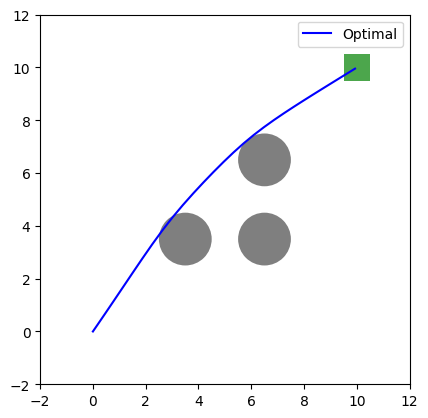

In [4]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [18]:
# w_bad = np.random.uniform(0.0, 1.0, size=w_des.shape)
w_run = np.array([10, .1, .1, 0, 0, 0])
w_term = np.array([1000, .1, .1, 0, 0, 0])
w_bad = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
w_bad /= np.max(w_bad)
# w_bad = w_des
w_run = w_bad[:nr]
w_term = w_bad[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_non_opt = mim_solvers.SolverSQP(problem)
sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_non_opt.with_callbacks=False
sqp_non_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_non_opt.solve(xs_init, us_init, 500)
xs_non_optimal = sqp_non_opt.xs.copy()
us_non_optimal = sqp_non_opt.us.copy()
print(sqp_non_opt.cost)

1.2786729294034338


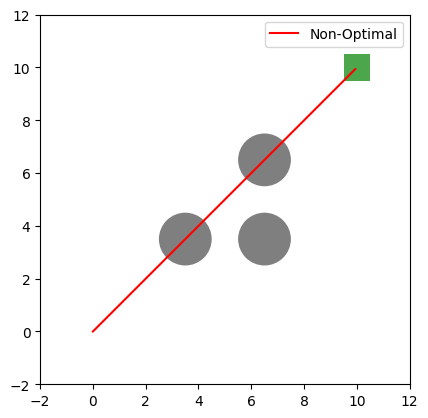

In [19]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [21]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w_single(x, cost_set, xs_optimal, us_optimal, xs_non_optimal, us_non_optimal, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    den += np.exp(-cost_set.traj_cost(xs_non_optimal, us_non_optimal, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_multiple(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    for X, U in zip(xs_non_optimal_set, us_non_optimal_set):
        den += np.exp(-cost_set.traj_cost(X, U, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

In [37]:
dt = timeStep
Lambda = 0.0
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 1000, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
loop_tol = 0.001
e = 1
e_prev = np.inf
x0 = w_bad
it = 0
it_max = 1000
xs = []
us = []
ws = []
xs.append(np.vstack(xs_non_optimal).copy())
us.append(np.vstack(us_non_optimal).copy())
ws.append(w_bad)
while e > loop_tol and it < it_max:
    res = minimize(fcn_w_multiple, 
                   x0, 
                   args=(cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    # res = minimize(fcn_w_single, 
    #                x0, 
    #                args=(cost_set, xs_optimal, us_optimal, xs_non_optimal, us_non_optimal, dt, Lambda), 
    #                bounds=bnds, 
    #                method='L-BFGS-B', 
    #                tol = tol,
    #                options=options)
    w_loop = res.x.copy()
    w_loop /= np.max(w_loop)
    w_run = w_loop[:nr]
    w_term = w_loop[nr:]
    for i in range(T):
        sqp_non_opt.problem.runningModels[i].differential.model.costWeights = w_run
    sqp_non_opt.problem.terminalModel.differential.model.costWeights = w_term
    # done = sqp_non_opt.solve(xs_non_optimal.tolist(), us_non_optimal.tolist(), 100)
    done = sqp_non_opt.solve(xs_init, us_init, 100)
    xs_non_optimal = sqp_non_opt.xs.copy()
    us_non_optimal = sqp_non_opt.us.copy()
    e = np.linalg.norm(np.vstack(xs_optimal) - np.vstack(xs_non_optimal))
    if e < e_prev:
        xs.append(np.vstack(xs_non_optimal).copy())
        us.append(np.vstack(us_non_optimal).copy())
        ws.append(w_loop.copy())
        x0 = w_loop.copy()
        e_prev = e
    print('Error: ', e, 'Traj Cost: ', sqp_non_opt.cost)
    it += 1

print(res)
w_irl = res.x

Error:  81.13363624680974 Traj Cost:  2.8666647958272147e-05
Error:  17.478346242868042 Traj Cost:  33.577355230961786
Error:  17.22431504601203 Traj Cost:  23.912343778052747
Error:  29.192491247346876 Traj Cost:  29.00805678932135
Error:  29.192491247346876 Traj Cost:  29.00805678932135
Error:  29.192491247346876 Traj Cost:  29.00805678932135
Error:  29.192491247346876 Traj Cost:  29.00805678932135
Error:  29.192491247346876 Traj Cost:  29.00805678932135
Error:  29.192491247346876 Traj Cost:  29.00805678932135
Error:  29.192491247346876 Traj Cost:  29.00805678932135
Error:  29.192491247346876 Traj Cost:  29.00805678932135
Error:  29.192491247346876 Traj Cost:  29.00805678932135
Error:  29.192491247346876 Traj Cost:  29.00805678932135
Error:  29.192491247346876 Traj Cost:  29.00805678932135


KeyboardInterrupt: 

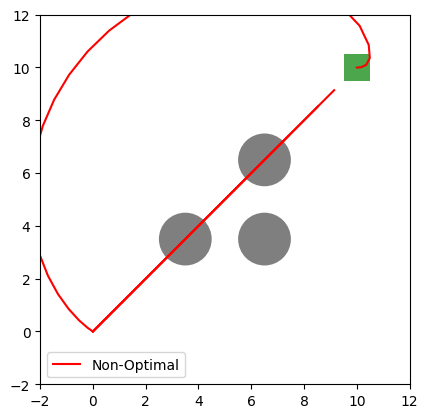

In [38]:
plot_1_set(xs, obs_set, target_high, 'Non-Optimal', 'r', 'r')

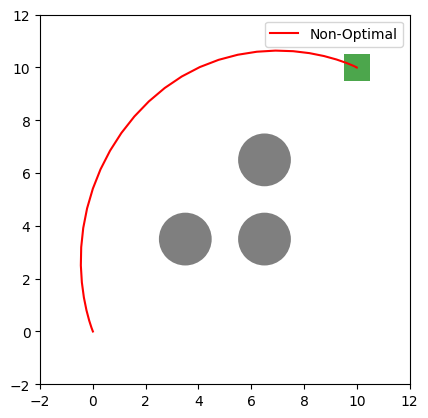

In [31]:
plot_1_traj(xs[1], obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [32]:
print('Desired: ')
print('Running ==>    ', w_des[:nr])
print('Terminal ==>   ', w_des[nr:])
print('IRL: ')
print('Running ==>    ', ws[1][:nr])
print('Terminal ==>   ', ws[1][nr:])

Desired: 
Running ==>     [1.0e-02 1.0e-04 1.0e-04 2.0e-01 1.5e-01 1.0e-01]
Terminal ==>    [1.0e+00 1.0e-04 1.0e-04 1.0e-01 1.5e-01 2.0e-01]
IRL: 
Running ==>     [0.         0.         0.         0.04473954 0.07475163 0.01772258]
Terminal ==>    [1.00000000e+00 0.00000000e+00 1.89960644e-05 1.99894350e-03
 1.54096513e-01 8.88965379e-03]


In [ ]:
print('Desired: ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs_non_optimal, us_non_optimal, dt, Lambda)) 
print('IRL:     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs_non_optimal, us_non_optimal, dt, Lambda))